In [1]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import os
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [2]:
"""INDEX 1"""
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.page_count)]
"""INDEX 1"""

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [3]:
page_num = 100
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)
image;

In [12]:
block_lst = pages[page_num].get_text("dict")['blocks']
block_lst[0]['lines'][0]['spans']

[{'size': 8.954887390136719,
  'flags': 4,
  'font': 'Times-Roman',
  'color': 0,
  'ascender': 0.75,
  'descender': -0.25,
  'text': 'NOUVELLE FLORE ',
  'origin': (173.52000427246094, 24.239990234375),
  'bbox': (173.52000427246094,
   17.489990234375,
   253.91488647460938,
   26.489990234375)}]

In [42]:
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
dy_block_lst = []
x0, y0, x1, y1 = 0, 0, 0, 0
myFont = ImageFont.truetype("Arial", 15)
g_i = 0
#block_lst = dict(block_lst)
for b in block_lst:
    if b['type'] == 0:
        x0_b, y0_b, x1_, y1_b = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
        draw.rectangle((x0_b, y0_b, x1_, y1_b), fill=None, outline=ImageColor.getrgb("#8100bb"), width = 1)
        blank_draw.rectangle((x0_b, y0_b, x1_, y1_b), fill=None, outline=ImageColor.getrgb("#8100bb"), width = 1)
        for l in b['lines']:
            #for s in l['spans']:
            #    for w in s['text']:
            prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
            #print(y0, prev_y1)
            w = 1 
            if x0 > 300 and x1 < 1400: 
                w = 5
            draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = w)
            dy = y0 - prev_y1
            dy_block_lst.append(dy)
            blank_draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = w)
            blank_draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
            draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
            
            l['line_group'] = g_i
            #print(dy)
            if prev_y1 == 0 or dy > 15:
                g_i += 1

            blank_draw.text((prev_x1, prev_y1), str(l['line_group']), font=myFont, fill =(0, 0, 255))
            draw.text((prev_x1, prev_y1), str(l['line_group']), font=myFont, fill =(0, 0, 255))
        

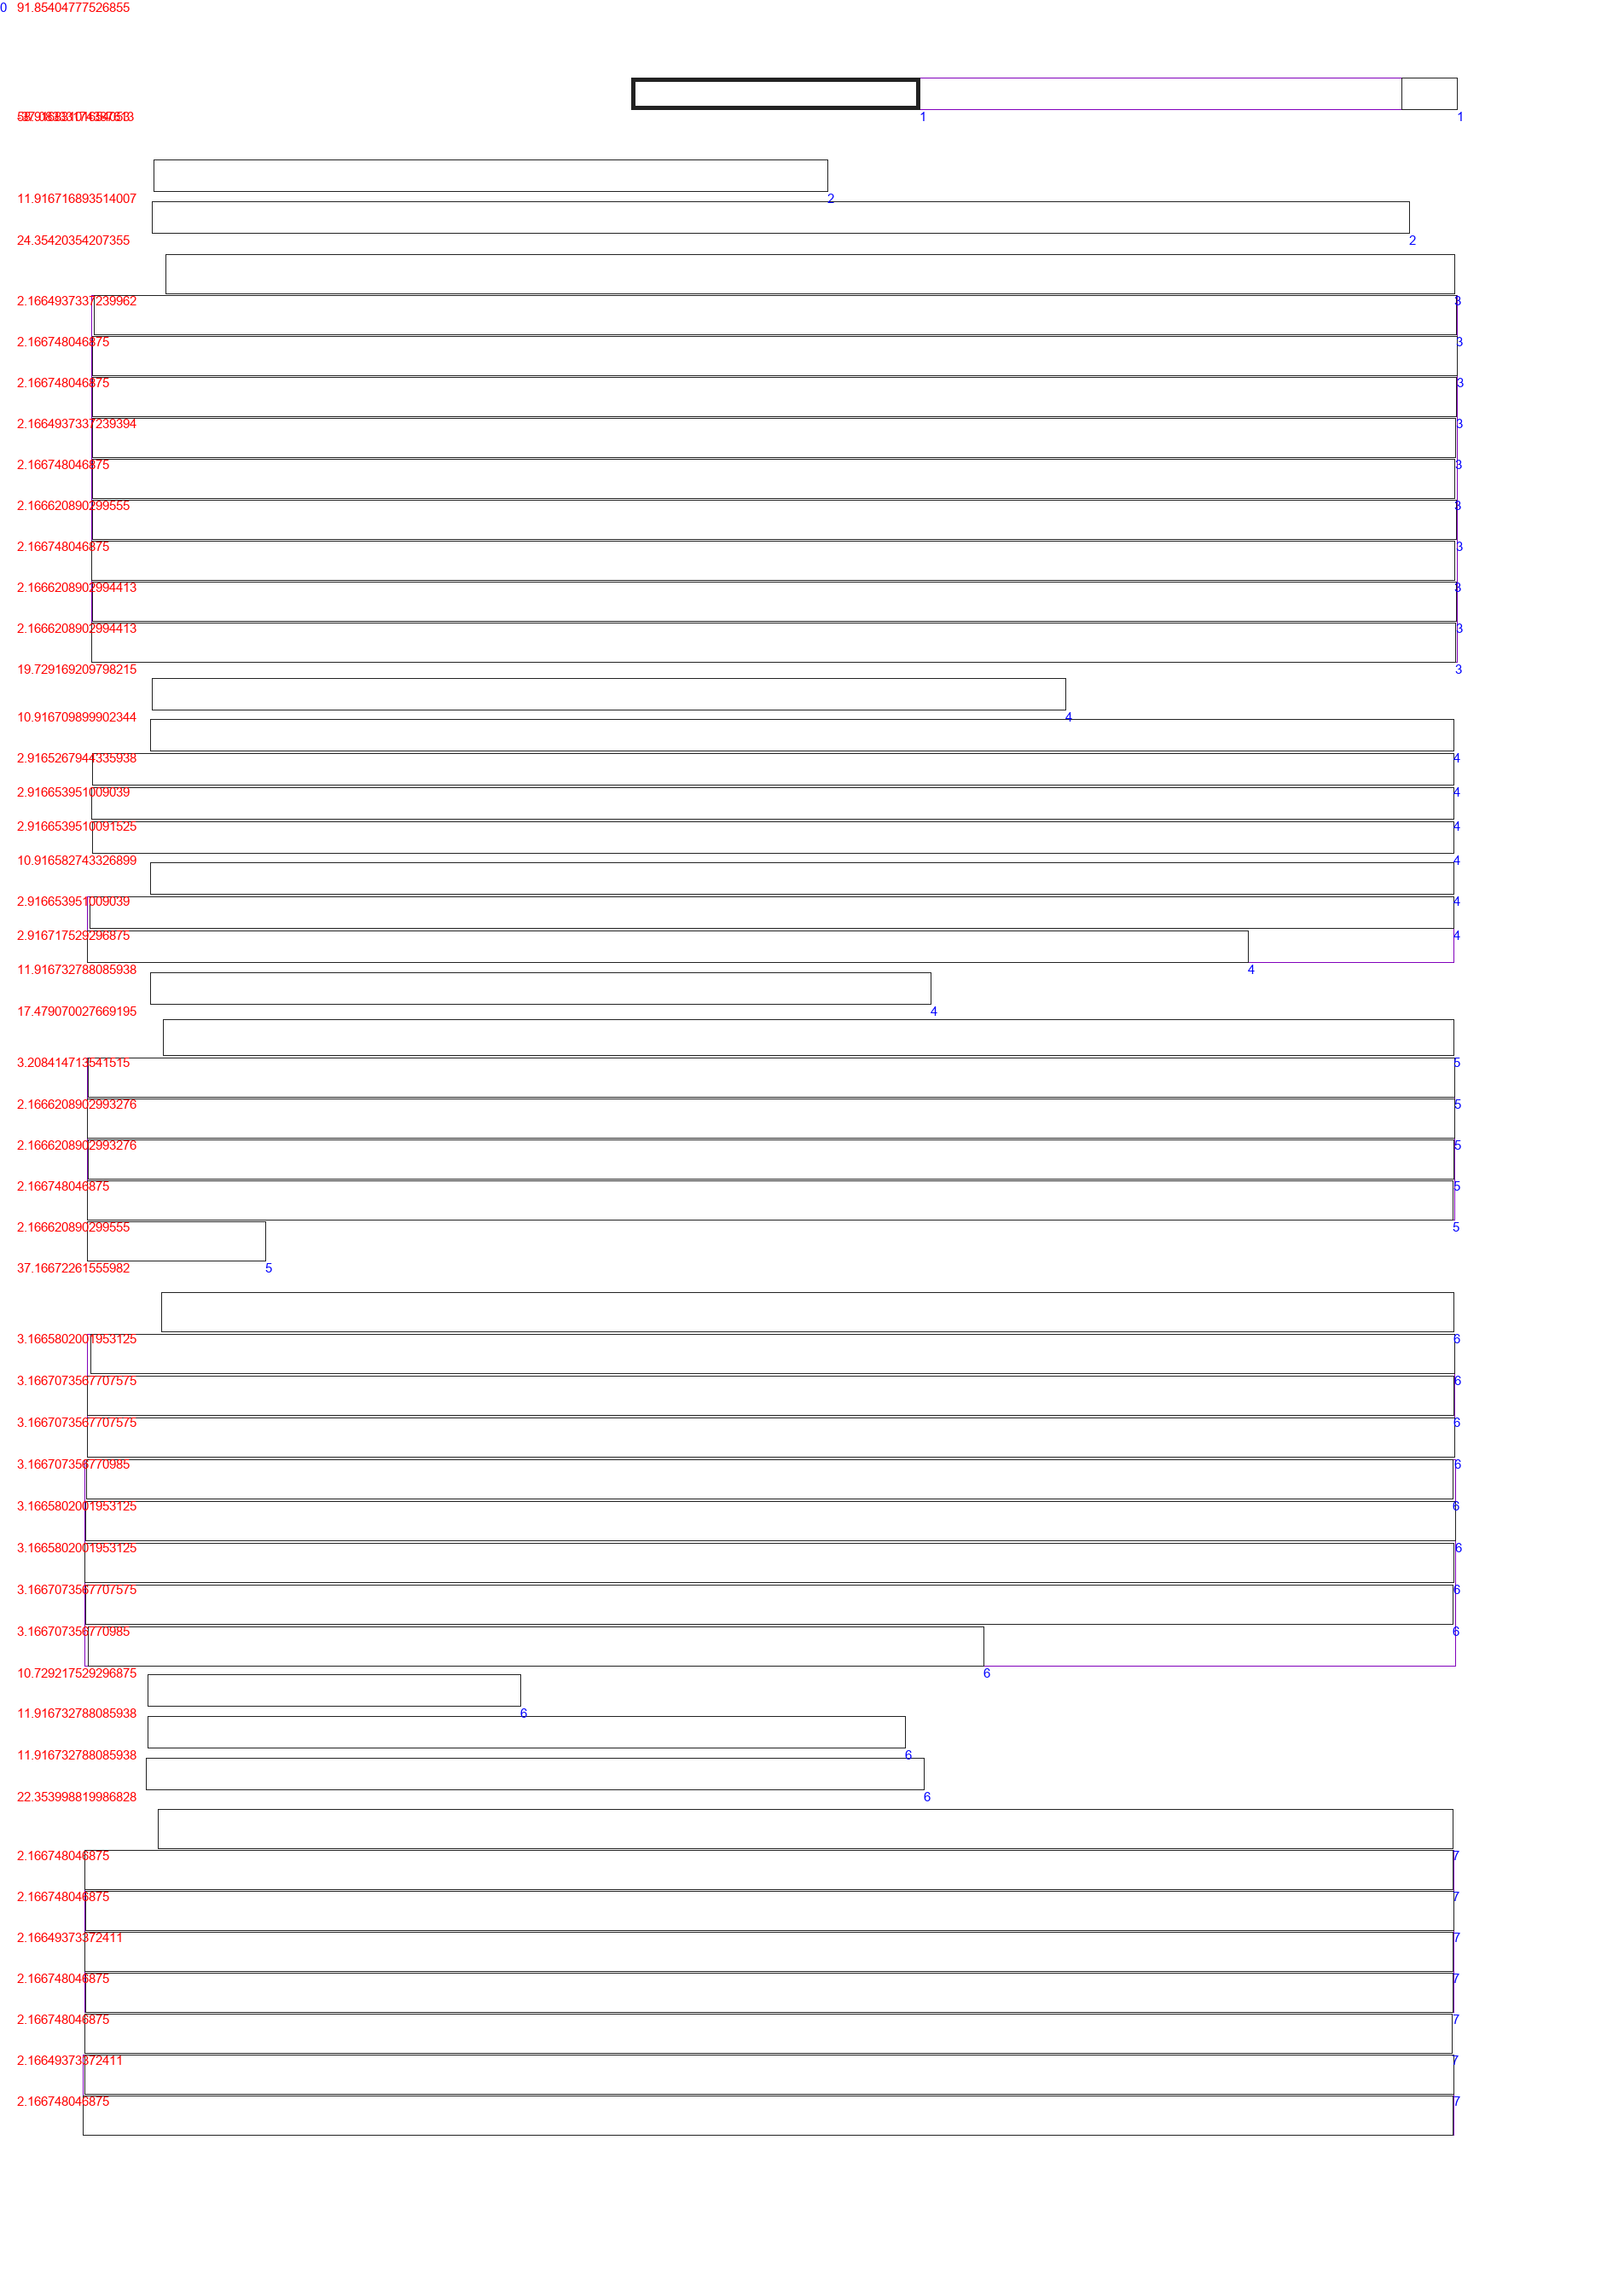

In [43]:
blank_im

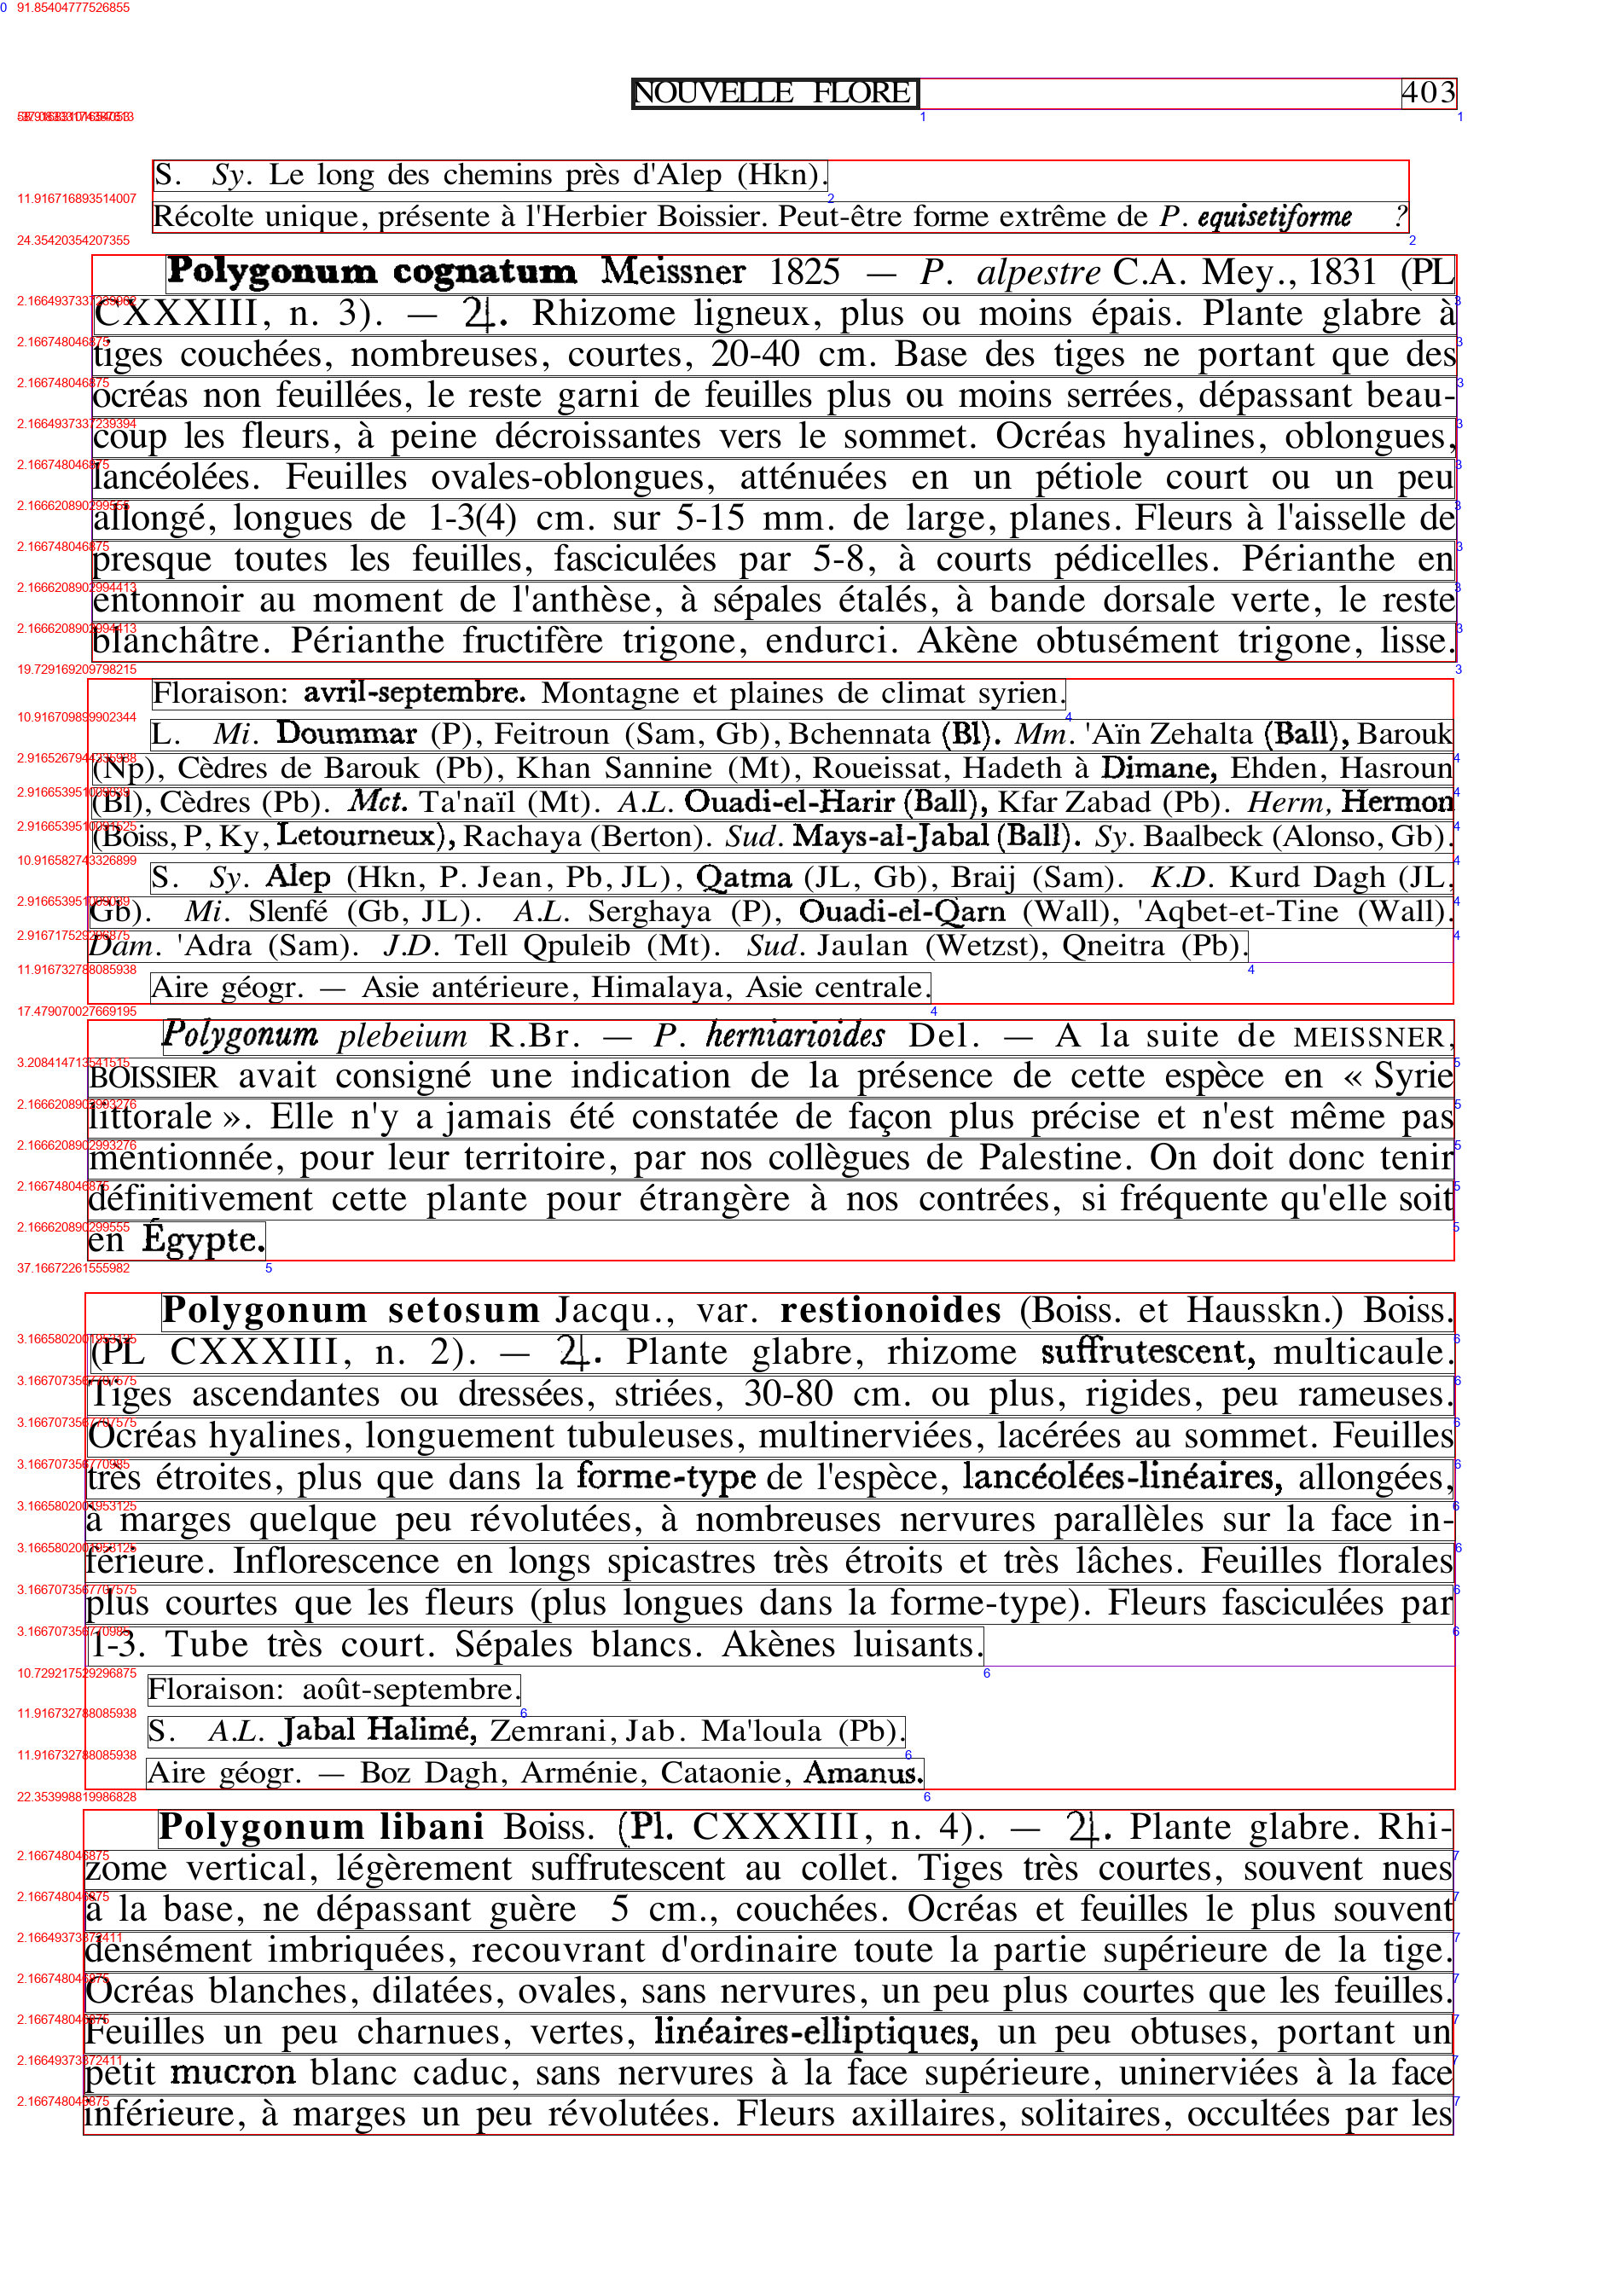

In [44]:
image

In [45]:
colors21 = ['#800000', '#e6194B', '#fabed4', 
            '#9A6324', '#f58231', '#ffd8b1', '#fffac8', '#ffe119',
            '#808000', '#bfef45', '#3cb44b', '#aaffc3', '#469990',
            '#42d4f4', '#4363d8', '#000075',
            '#911eb4', '#dcbeff', '#f032e6', 
            '#a9a9a9', '#000000']

colors7 = ['#ff0000', '#ffa500', '#ffff00', '#008000', '#0000ff', '#4b0082', '#ee82ee']

In [46]:
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
draw = ImageDraw.Draw(image)
myFont = ImageFont.truetype("Arial", 15)

def group_blocks(block_lst, dy_threshold):
    x0, y0, x1, y1 = 0, 0, 0, 0
    g_i = -1 #just because we will definitly add 1 to g_1 as prev_y1 will start at 0 first
    for b in block_lst:
        if b['type'] == 0:
            prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
            #print(y0, prev_y1)
            #draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
            dy = y0 - prev_y1
            #dy_block_lst.append(dy)
            #blank_draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
            #blank_draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
            #draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        
            if prev_y1 == 0 or dy > dy_threshold:
                g_i += 1

            b['block_group'] = g_i

            #blank_draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
            #draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))

def draw_groups(draw, color_lst = colors7):
    block_no = -1
    color = color_lst[0]
    for b in block_lst:
        if b['type'] == 0:
            block_no, prev_block_no = b['block_group'], block_no
            if block_no != 0 and block_no != prev_block_no:
                #color = color_lst[block_no%len(color_lst)]
                group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
                w = 1 
                if group_x0 > 300 and group_x1 < 1400: 
                    w = 5
                draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
            if block_no != prev_block_no: 
                x0_lst, y0_lst, x1_lst, y1_lst = [], [], [], []
            
            prev_block_no = block_no
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
            x0_lst.append(x0)
            y0_lst.append(y0)
            x1_lst.append(x1)
            y1_lst.append(y1)
    #draw last one
    #color = color_lst[block_no%len(color_lst)]
    group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
    w = 1 
    if group_x0 > 300 and group_x1 < 1400: 
        w = 5
    draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)


In [49]:
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
draw = ImageDraw.Draw(image)
myFont = ImageFont.truetype("Arial", 15)

def group_lines(block_lst, dy_threshold):
    x0, y0, x1, y1 = 0, 0, 0, 0
    g_i = -1 #just because we will definitly add 1 to g_1 as prev_y1 will start at 0 first
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
                x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
                dy = y0 - prev_y1
                if prev_y1 == 0 or dy > dy_threshold:
                    g_i += 1
                l['line_group'] = g_i

def draw_line_groups(draw, color_lst = colors7):
    line_group = -1
    color = color_lst[0]
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                line_group, prev_line_group = l['line_group'] , line_group
                if line_group != 0 and line_group != prev_line_group:
                    group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
                    w = 1 
                    if group_x0 > 300 and group_x1 < 1400: 
                        w = 5
                    draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
                if line_group != prev_line_group: 
                    x0_lst, y0_lst, x1_lst, y1_lst = [], [], [], []
                
                prev_line_group = line_group
                x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
                x0_lst.append(x0)
                y0_lst.append(y0)
                x1_lst.append(x1)
                y1_lst.append(y1)
    #draw last one
    #color = color_lst[block_no%len(color_lst)]
    group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
    w = 1 
    if group_x0 > 300 and group_x1 < 1400: 
        w = 5
    draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)



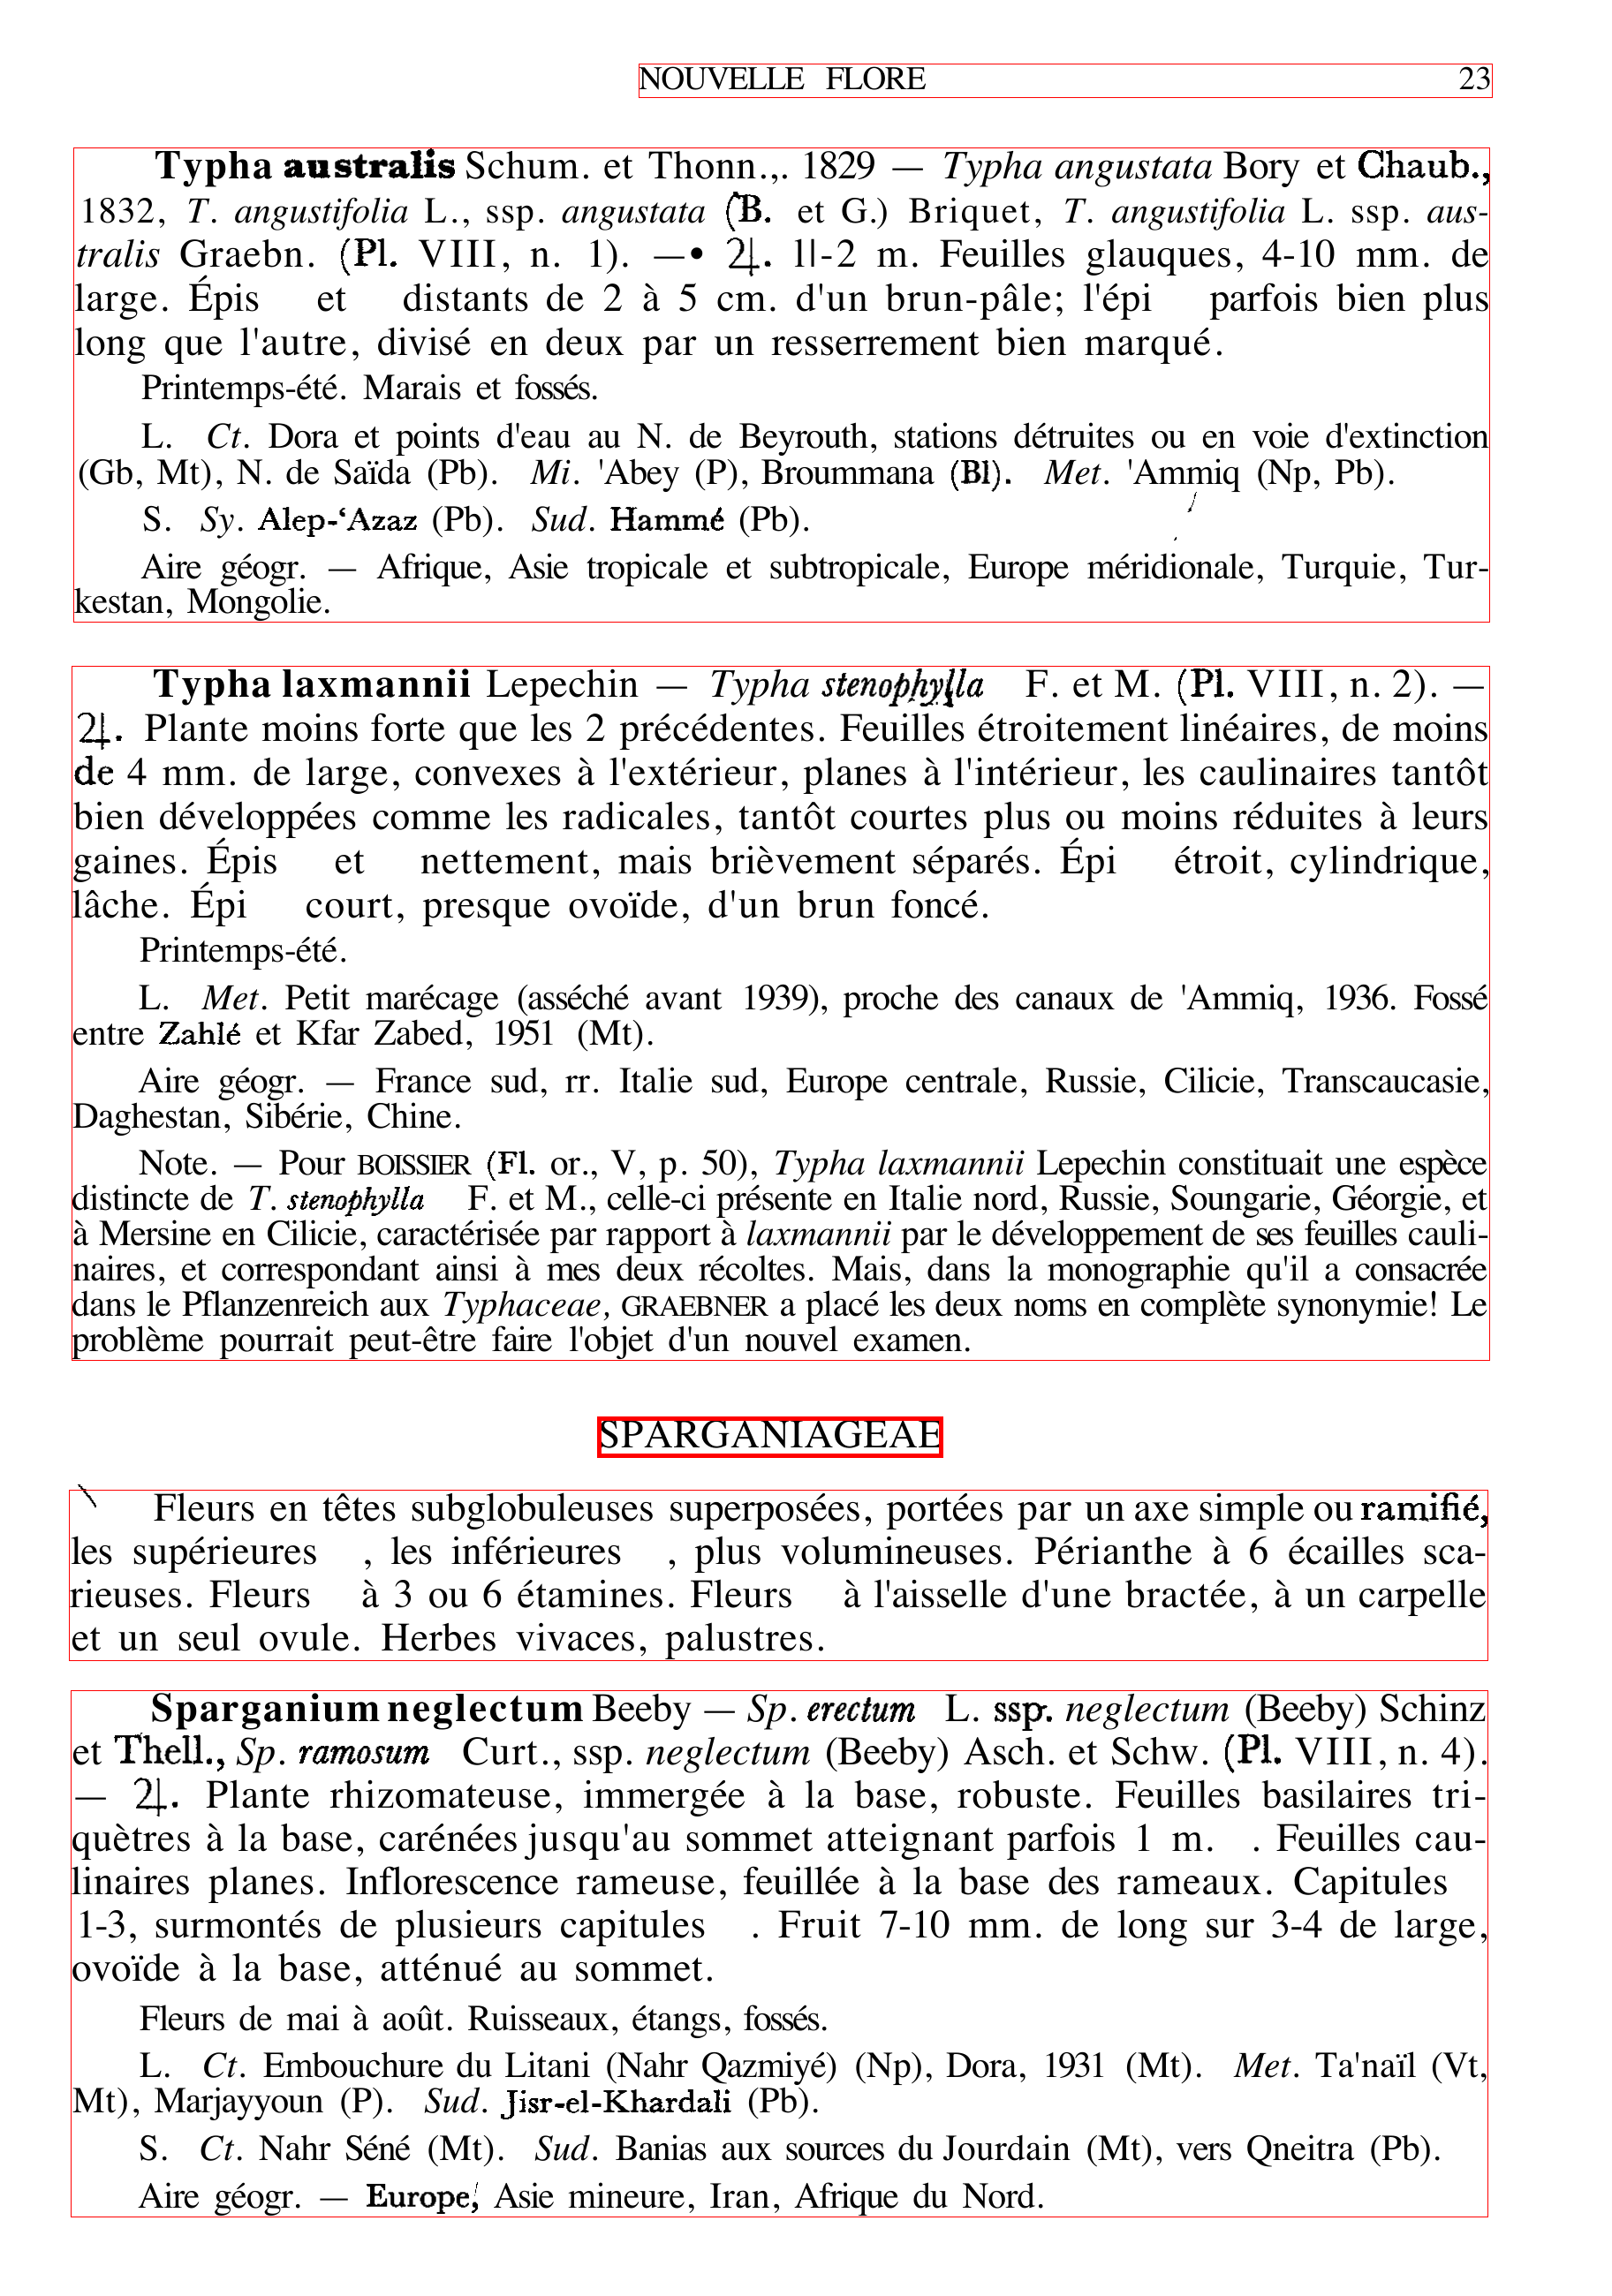

In [50]:
myFont = ImageFont.truetype("Arial", 15)

page_num = 100
block_lst = pages[page_num].get_text("dict")['blocks']
group_lines(block_lst, 15)

pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)
draw_line_groups(draw)
image

# YAY

In [54]:
#Setting up files and directories for saving the results
SCRIPT_NAME = "lines_grouping"
SCRIPT_OUTPUT_PATH = "../output/main_text/" + SCRIPT_NAME + "/" 
DATE_STR = datetime.now().strftime("%Y_%m_%d") 
TIME_STR = datetime.now().strftime("%H%M")
QUICK_FIX = False
TAIL_STR = ''

if QUICK_FIX:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/QuickFix/" 
    #TAIL_STR = '_' + DATE_STR + '_' + TIME_STR
else:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/" + TIME_STR + "/"

try:
    os.makedirs(OUTPUT_PATH)
except FileExistsError:
    # directory already exists
    pass

In [55]:
result_ims = []

myFont = ImageFont.truetype("Arial", 15)

for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    block_lst = pages[page_num].get_text("dict")['blocks']
    group_lines(block_lst, 10)
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    draw_line_groups(draw)
    result_ims.append(image)

result_ims[0].save(OUTPUT_PATH + 'colored_blocks_3rdquarter.pdf',save_all=True, append_images=result_ims[1:])

100%|██████████| 160/160 [00:31<00:00,  5.12it/s]


Find center ✅

In [53]:
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
draw = ImageDraw.Draw(image)
myFont = ImageFont.truetype("Arial", 15)

def group_lines(block_lst, dy_threshold):
    x0, y0, x1, y1 = 0, 0, 0, 0
    g_i = -1 #just because we will definitly add 1 to g_1 as prev_y1 will start at 0 first
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
                x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
                dy = y0 - prev_y1
                if prev_y1 == 0 or dy > dy_threshold:
                    g_i += 1
                l['line_group'] = g_i

def draw_line_groups(draw, color_lst = colors7):
    line_group = -1
    color = color_lst[0]
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                line_group, prev_line_group = l['line_group'] , line_group
                if line_group != 0 and line_group != prev_line_group:
                    group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
                    w = 1 
                    if group_x0 > 300 and group_x1 < 1400: 
                        w = 5
                    draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
                if line_group != prev_line_group: 
                    x0_lst, y0_lst, x1_lst, y1_lst = [], [], [], []
                
                prev_line_group = line_group
                x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in l['bbox']]
                x0_lst.append(x0)
                y0_lst.append(y0)
                x1_lst.append(x1)
                y1_lst.append(y1)
    #draw last one
    #color = color_lst[block_no%len(color_lst)]
    group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
    w = 1 
    if group_x0 > 300 and group_x1 < 1400: 
        w = 5
    draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)



so now we need to make a database using these line_group thingies
- basically what happens in pre processing 
- then for each line group see if first line / first 5 words are 1) bolded / start with var etc
    - basically this check aaron's code
- then concatenate the ones that are supposed to be under one (so until next "break point" -- in fact need to define "break points")
    - after we group everything together then run Aaron's code?
    -  perhaps even save db and basically run aaron's code on that?
- need to start from beggining of all pages till break points

break points: 
- new genus: catagorized by first letter all caps
- last right indent (for dicotimist key)
- new "family" (centered stuff)
- new page (just for now)
- bold / italicized / var. spp words in the first 5 words?
- L. S. ... words like this at the beggining : merge with the upper one 
- if just italicized -- ignore

things to "remove/ignore":
- page number 
- novile flore
- dicotomist key (check if it always comes right after genus description)

In [69]:
def flags_decomposer(flags):
    """Make font flags human readable."""
    l = []
    if flags & 2 ** 0:
        l.append("superscript")
    if flags & 2 ** 1:
        l.append("italic")
    if flags & 2 ** 2:
        l.append("serifed")
    else:
        l.append("sans")
    if flags & 2 ** 3:
        l.append("monospaced")
    else:
        l.append("proportional")
    if flags & 2 ** 4:
        l.append("bold")
    return l

In [77]:
def draw_flagged(draw, block_lst):
    for b in block_lst:
        if b['type'] == 0:
            for l in b['lines']:
                for s in l['spans']:
                    x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in s['bbox']]
                    if 'italic' in flags_decomposer(s['flags']) and 'bold' in  flags_decomposer(s['flags']):
                        color = '#000000'
                        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = 5)
                    elif 'bold' in  flags_decomposer(s['flags']):
                        color = '#00008b'
                        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = 5)
                    elif 'italic' in flags_decomposer(s['flags']):
                        color = '#8b008b'
                        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = 5)

result_ims_flags = []

myFont = ImageFont.truetype("Arial", 15)

for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    block_lst = pages[page_num].get_text("dict")['blocks']
    #group_lines(block_lst, 10)
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    #draw_line_groups(draw)
    draw_flagged(draw, block_lst)
    result_ims_flags.append(image)

result_ims_flags[0].save(OUTPUT_PATH + 'flags.pdf',save_all=True, append_images=result_ims_flags[1:])

100%|██████████| 160/160 [00:30<00:00,  5.19it/s]


In [68]:
# https://pymupdf.readthedocs.io/en/latest/faq/#how-to-analyze-font-characteristics

#import fitz
#import pprint, re

def flags_decomposer(flags):
    """Make font flags human readable."""
    l = []
    if flags & 2 ** 0:
        l.append("superscript")
    if flags & 2 ** 1:
        l.append("italic")
    if flags & 2 ** 2:
        l.append("serifed")
    else:
        l.append("sans")
    if flags & 2 ** 3:
        l.append("monospaced")
    else:
        l.append("proportional")
    if flags & 2 ** 4:
        l.append("bold")
    return l

flags_decomposer(6)
#if 'italic' in flags_decomposer(6):


['italic', 'serifed', 'proportional']